**Data Preprocessing/Preparation/Cleaning** steps include the following:

1. Missing value handling.
2. Feature Extraction and Selection
3. Feature Scaling

**Missing Value Handling:**

From EDA, we found that CREDIT_LIMIT and MINIMUM_PAYMENTS features have missing values.

Imputing these missing values with mean or median will be problematic since both variables don't follow a normal distribution and are heavily skewed. For example, what if the imputed minimum_payment with mean/median doesn't make meaningful sense when compared with values of other features like balance, payments. Example, if you have high MAB and no payments made then in span of 12 months the minimum payments due would have grown exponentially with the interest rate and could be high but mean/median wouldn't capture these. So, KNN imputation will be the best fit since it predicts the missing values with the approximation from the data points' nearest neighbours instead of generalizing a same value for all missing values.

In [4]:
from fancyimpute import KNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [5]:
# load dataset
data = pd.read_csv('credit-card-data.csv')
data.drop('CUST_ID',axis=1,inplace=True)

In [6]:
#Apply KNN imputation algorithm
data = pd.DataFrame(KNN(k = 3).fit_transform(data), columns = data.columns)

Imputing row 1/8950 with 0 missing, elapsed time: 81.247
Imputing row 101/8950 with 0 missing, elapsed time: 81.257
Imputing row 201/8950 with 0 missing, elapsed time: 81.268
Imputing row 301/8950 with 0 missing, elapsed time: 81.275
Imputing row 401/8950 with 0 missing, elapsed time: 81.283
Imputing row 501/8950 with 0 missing, elapsed time: 81.289
Imputing row 601/8950 with 0 missing, elapsed time: 81.295
Imputing row 701/8950 with 0 missing, elapsed time: 81.301
Imputing row 801/8950 with 0 missing, elapsed time: 81.308
Imputing row 901/8950 with 0 missing, elapsed time: 81.319
Imputing row 1001/8950 with 0 missing, elapsed time: 81.330
Imputing row 1101/8950 with 0 missing, elapsed time: 81.339
Imputing row 1201/8950 with 0 missing, elapsed time: 81.344
Imputing row 1301/8950 with 0 missing, elapsed time: 81.347
Imputing row 1401/8950 with 0 missing, elapsed time: 81.350
Imputing row 1501/8950 with 0 missing, elapsed time: 81.354
Imputing row 1601/8950 with 0 missing, elapsed time:

In [7]:
#Variables with Missing Value percentage
data.apply(lambda x: sum(x.isnull()/len(data))*100)

BALANCE                             0.0
BALANCE_FREQUENCY                   0.0
PURCHASES                           0.0
ONEOFF_PURCHASES                    0.0
INSTALLMENTS_PURCHASES              0.0
CASH_ADVANCE                        0.0
PURCHASES_FREQUENCY                 0.0
ONEOFF_PURCHASES_FREQUENCY          0.0
PURCHASES_INSTALLMENTS_FREQUENCY    0.0
CASH_ADVANCE_FREQUENCY              0.0
CASH_ADVANCE_TRX                    0.0
PURCHASES_TRX                       0.0
CREDIT_LIMIT                        0.0
PAYMENTS                            0.0
MINIMUM_PAYMENTS                    0.0
PRC_FULL_PAYMENT                    0.0
TENURE                              0.0
dtype: float64

In [8]:
data.to_csv('credit_card_knn_imputed.csv', index = False)

**Feature Engineering - Deriving new KPIs**

1. Monthly Average Purchase(MAP) = Total Purchases/Tenure --> Regular purchasers?
2. Monthly Average Cash Advance(MA_CA) = Total Cash Advance/Tenure  --> Regular withdrawers?
3. Average Amount per purchase(PURCHASES_TRX) --> High value purchasers(Luxurious) or Low value purchasers(Economic)?
4. Customer Purchase Behaviour as Categorical Value by Purchase type. Categories - One-off, Installments, Both, None
5. Limit Usage(balance to credit limit ratio) --> High Credit Utilization lead to lower credit score.
6. Payments to minimum payments ratio --> Higher the value, more desirable/low-risk customer.
7. PRC_FULL_PAYMENT -  Percentage of months with full payment of the due statement balance.

Desirable KPI values expected in a customer profile in an ideal case scenario - This may not be completely applicable in some contexts but will prove good as an initial generalization.
* High MAP
* Low MA_CA
* High average amount per purchase(not necessarily - depends)
* Both One_off and Installment purchase type
* Optimum(<30 percent) Limit_Usage
* High Pay_MinPay Ratio
* Reasonably high Full Payment - Too low might indicate financially unstable customer.

In [9]:
data['MA_PURCHASE'] = data['PURCHASES']/data['TENURE']
data['MA_CASH_ADVANCE'] = data['CASH_ADVANCE']/data['TENURE']
data['LIMIT_USAGE'] = data['BALANCE']/data['CREDIT_LIMIT']
data['PAY_MINPAY_RATIO'] = data['PAYMENTS']/data['MINIMUM_PAYMENTS']

#drop purchases,cash_advance,tenure(less variability),Balance,CreditLimit

In [10]:
def purchase_type(data):
    if (data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']==0):
        return 'NONE'
    if (data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']>0):
         return 'BOTH'
    if (data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']==0):
        return 'ONE_OFF'
    if (data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']>0):
        return 'INSTALLMENT'

In [11]:
data['PURCHASE_TYPE']=data.apply(purchase_type,axis=1)

In [12]:
data = pd.concat([data,pd.get_dummies(data['PURCHASE_TYPE'],drop_first=True)],axis=1)
data_profile = data.copy()
data.drop(columns=['PURCHASE_TYPE','PURCHASES','CASH_ADVANCE','TENURE','BALANCE','CREDIT_LIMIT'
                  ,'PAYMENTS','MINIMUM_PAYMENTS'],axis=1,inplace=True)

In [13]:
data.shape

(8950, 17)

In [14]:
data.head()

,BALANCE_FREQUENCY,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,MA_PURCHASE,MA_CASH_ADVANCE,LIMIT_USAGE,PAY_MINPAY_RATIO,INSTALLMENT,NONE,ONE_OFF
0,0.818182,0.00,95.4,0.166667,0.000000,0.083333,0.000000,0.0,2.0,0.000000,7.950000,0.000000,0.040901,1.446508,1,0,0
1,0.909091,0.00,0.0,0.000000,0.000000,0.000000,0.250000,4.0,0.0,0.222222,0.000000,536.912124,0.457495,3.826241,0,1,0
2,1.000000,773.17,0.0,1.000000,1.000000,0.000000,0.000000,0.0,12.0,0.000000,64.430833,0.000000,0.332687,0.991682,0,0,1
3,0.636364,1499.00,0.0,0.083333,0.083333,0.000000,0.083333,1.0,1.0,0.000000,124.916667,17.149001,0.222223,0.000000,0,0,1
4,1.000000,16.00,0.0,0.083333,0.083333,0.000000,0.000000,0.0,1.0,0.000000,1.333333,0.000000,0.681429,2.771075,0,0,1


**Outlier Effect Mitigation and Feature Scaling**

In [15]:
# log tranformation
data_logT =data[['BALANCE_FREQUENCY', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'PRC_FULL_PAYMENT','MA_PURCHASE', 'MA_CASH_ADVANCE', 'LIMIT_USAGE',
       'PAY_MINPAY_RATIO']].applymap(lambda x: np.log(x+1))

In [16]:
data_logT = pd.concat([data_logT,data[['NONE','ONE_OFF','INSTALLMENT']]],axis=1)

In [17]:
from sklearn.preprocessing import  MinMaxScaler
mm=MinMaxScaler()
data_scaled=mm.fit_transform(data_logT)

***Customer Profiling - Insights from KPIs***

Building customer profiles based on the Purchase type

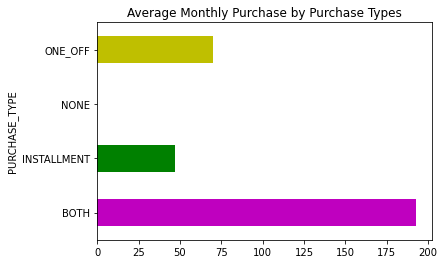

In [18]:
data_profile.groupby('PURCHASE_TYPE').apply(lambda x: np.mean(x['MA_PURCHASE'])).plot.barh(color=['m','g','b','y'])
plt.title('Average Monthly Purchase by Purchase Types')
plt.savefig("Monthly_Average_Purchase_by_PurchaseType.png")

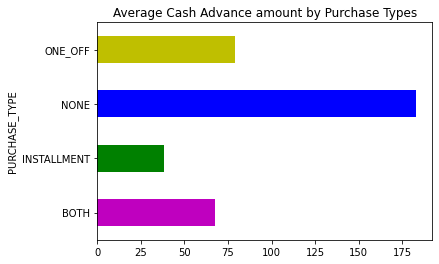

In [19]:
data_profile.groupby('PURCHASE_TYPE').apply(lambda x: np.mean(x['MA_CASH_ADVANCE'])).plot.barh(color=['m','g','b','y'])
plt.title('Average Cash Advance amount by Purchase Types')
plt.savefig("Cash_Advance_by_PurchaseType.png")

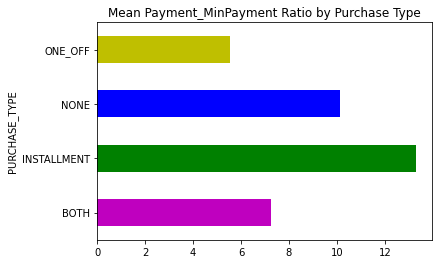

In [20]:
data_profile.groupby('PURCHASE_TYPE').apply(lambda x: np.mean(x['PAY_MINPAY_RATIO'])).plot.barh(color=['m','g','b','y'])
plt.title('Mean Payment_MinPayment Ratio by Purchase Type')
plt.savefig("Pay_MinPay_Ratio_by_PurchaseType.png")

**APPLY PCA for dimensionality reduction before doing clustering**

In [21]:
from sklearn.decomposition import PCA

In [22]:
data_scaled.shape

(8950, 17)

In [23]:
var_ratio={}
for n in range(2,17):
    pc=PCA(n_components=n)
    data_pca=pc.fit(data_scaled)
    var_ratio[n]=sum(data_pca.explained_variance_ratio_)
    
var_ratio

{2: 0.6647026760427495,
 3: 0.7893223162828045,
 4: 0.8578021417574633,
 5: 0.9054151892556068,
 6: 0.933576375314599,
 7: 0.954806894622997,
 8: 0.9724862856745238,
 9: 0.9790116758417162,
 10: 0.9844170372450451,
 11: 0.9888177035104553,
 12: 0.9927518121671768,
 13: 0.994944446888037,
 14: 0.9967781399875608,
 15: 0.9985597152460924,
 16: 0.9996874774646334}

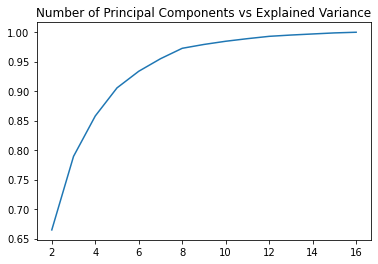

In [24]:
pd.Series(var_ratio).plot(title='Number of Principal Components vs Explained Variance')
plt.savefig("PCA Explained Variance Graph.png")

In [25]:
pca_final=PCA(n_components=4).fit(data_scaled)
PC_data=pca_final.fit_transform(data_scaled)
PC_data=pd.DataFrame(PC_data)

In [26]:
# Factor Analysis : variance explained by each component- 
pd.Series(pca_final.explained_variance_ratio_,index=['PC_'+ str(i) for i in range(1,5)])

PC_1    0.433678
PC_2    0.231025
PC_3    0.124620
PC_4    0.068480
dtype: float64

In [27]:
PCA_insight = pd.DataFrame(pca_final.components_.T, columns=['PC_' +str(i) for i in range(1,5)],index=data.columns)
PCA_insight.abs().sort_values('PC_1',ascending=False)

,PC_1,PC_2,PC_3,PC_4
PURCHASES_FREQUENCY,0.457973,0.042735,0.143886,0.078969
PURCHASES_INSTALLMENTS_FREQUENCY,0.430431,0.205756,0.227337,0.081485
INSTALLMENT,0.412867,0.229206,0.329057,0.300744
INSTALLMENTS_PURCHASES,0.330985,0.144636,0.168144,0.022573
PURCHASES_TRX,0.259080,0.092403,0.102201,0.045260
MA_PURCHASE,0.249018,0.163512,0.023973,0.061746
ONE_OFF,0.226382,0.505847,0.473849,0.264564
MA_CASH_ADVANCE,0.205214,0.028817,0.305986,0.443530
ONEOFF_PURCHASES_FREQUENCY,0.154300,0.375162,0.220798,0.122099
PRC_FULL_PAYMENT,0.138458,0.034364,0.084263,0.551619


In [28]:
PCA_insight.abs().sort_values('PC_2',ascending=False)

,PC_1,PC_2,PC_3,PC_4
ONE_OFF,0.226382,0.505847,0.473849,0.264564
NONE,0.103243,0.498645,0.516751,0.241128
ONEOFF_PURCHASES,0.136336,0.445014,0.146679,0.021725
ONEOFF_PURCHASES_FREQUENCY,0.154300,0.375162,0.220798,0.122099
INSTALLMENT,0.412867,0.229206,0.329057,0.300744
PURCHASES_INSTALLMENTS_FREQUENCY,0.430431,0.205756,0.227337,0.081485
MA_PURCHASE,0.249018,0.163512,0.023973,0.061746
INSTALLMENTS_PURCHASES,0.330985,0.144636,0.168144,0.022573
PURCHASES_TRX,0.259080,0.092403,0.102201,0.045260
PURCHASES_FREQUENCY,0.457973,0.042735,0.143886,0.078969


**Clustering**

In [29]:
#Load required libraries
from sklearn.cluster import KMeans

#Estimate optimum number of clusters
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters).fit(PC_data.iloc[:,:])
    cluster_errors.append(clusters.inertia_)
    
#Create dataframe with cluster errors
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

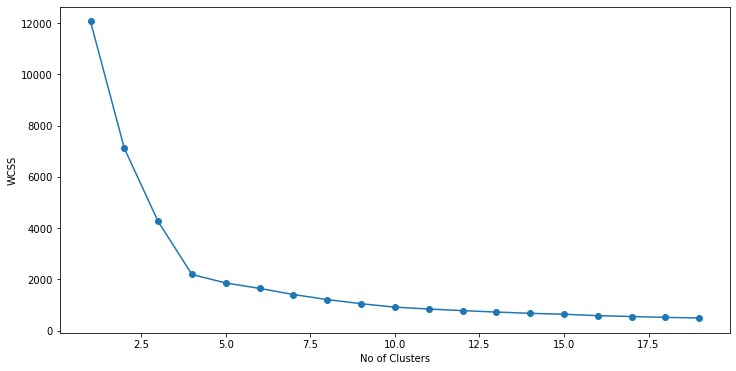

In [30]:
#Plot line chart to visualise number of clusters
%matplotlib inline  
plt.figure(figsize=(12,6))
plt.xlabel("No of Clusters")
plt.ylabel("WCSS")
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.savefig("No of Clusters vs WCSS.png")

In [31]:
#Implement kmeans
kmeans_model = KMeans(n_clusters = 4,random_state=0).fit(PC_data.iloc[:,:])

In [32]:
idx = np.argsort(kmeans_model.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(4)

In [33]:
kmeans_model.labels_

array([2, 1, 3, ..., 2, 1, 3])

In [34]:
# Conactenating labels found through Kmeans with data 
data_cluster=pd.concat([data[['MA_PURCHASE','MA_CASH_ADVANCE','LIMIT_USAGE','PAY_MINPAY_RATIO','PURCHASES_TRX'
                             ,'PRC_FULL_PAYMENT','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']],
                        pd.Series(lut[kmeans_model.labels_],name='Group')],axis=1)

In [35]:
data_cluster['Group'].unique()

array([1, 0, 2, 3], dtype=int64)

In [36]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
data_kpi_mean=data_cluster.groupby('Group')\
.apply(lambda x: x[['MA_PURCHASE','MA_CASH_ADVANCE','LIMIT_USAGE','PAY_MINPAY_RATIO',
                   'PURCHASES_TRX','PRC_FULL_PAYMENT','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']].mean()).T
data_kpi_mean

Group,0,1,2,3
MA_PURCHASE,0.020015,46.974347,69.020427,194.691699
MA_CASH_ADVANCE,182.971966,38.398206,78.608150,67.758271
LIMIT_USAGE,0.573546,0.271678,0.379681,0.354142
PAY_MINPAY_RATIO,10.107706,13.302770,5.496950,7.300158
PURCHASES_TRX,0.005379,11.900885,7.049370,33.317767
PRC_FULL_PAYMENT,0.044302,0.253031,0.101144,0.189974
ONEOFF_PURCHASES,0.148205,0.000000,778.365494,1393.653225
INSTALLMENTS_PURCHASES,0.091980,537.878469,0.937064,898.021821


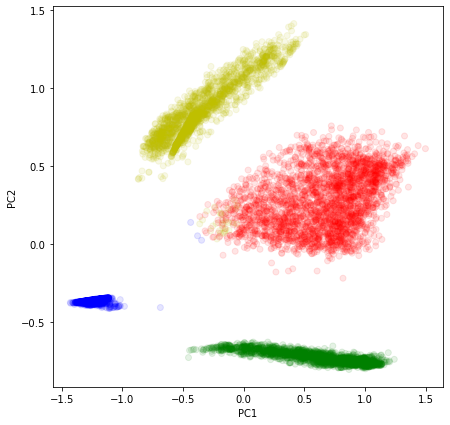

In [37]:
color_map={0:'r',1:'b',2:'g',3:'y'}
label_color=[color_map[l] for l in kmeans_model.labels_]
plt.figure(figsize=(7,7))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(PC_data.iloc[:,0],PC_data.iloc[:,1],c=label_color,cmap='Spectral',alpha=0.1)
plt.savefig("Clustering Results PC1 vs PC2.png")

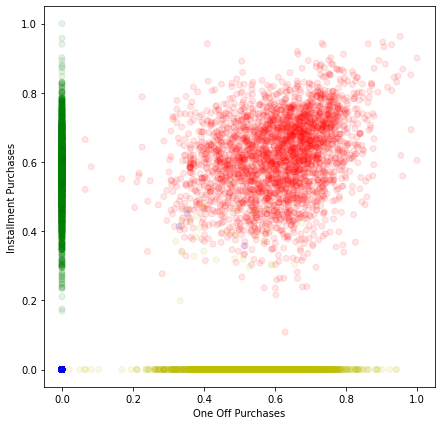

In [38]:
color_map={0:'r',1:'b',2:'g',3:'y'}
label_color=[color_map[l] for l in kmeans_model.labels_]
plt.figure(figsize=(7,7))
plt.xlabel('One Off Purchases')
plt.ylabel('Installment Purchases')
plt.scatter(data_scaled[:,1],data_scaled[:,2],c=label_color,cmap='Spectral',alpha=0.1)
plt.savefig("Clustering Results OneOff_Purchases vs Installment Purchases.png")

In [39]:
data.head()

,BALANCE_FREQUENCY,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,MA_PURCHASE,MA_CASH_ADVANCE,LIMIT_USAGE,PAY_MINPAY_RATIO,INSTALLMENT,NONE,ONE_OFF
0,0.818182,0.00,95.4,0.166667,0.000000,0.083333,0.000000,0.0,2.0,0.000000,7.950000,0.000000,0.040901,1.446508,1,0,0
1,0.909091,0.00,0.0,0.000000,0.000000,0.000000,0.250000,4.0,0.0,0.222222,0.000000,536.912124,0.457495,3.826241,0,1,0
2,1.000000,773.17,0.0,1.000000,1.000000,0.000000,0.000000,0.0,12.0,0.000000,64.430833,0.000000,0.332687,0.991682,0,0,1
3,0.636364,1499.00,0.0,0.083333,0.083333,0.000000,0.083333,1.0,1.0,0.000000,124.916667,17.149001,0.222223,0.000000,0,0,1
4,1.000000,16.00,0.0,0.083333,0.083333,0.000000,0.000000,0.0,1.0,0.000000,1.333333,0.000000,0.681429,2.771075,0,0,1


In [40]:
Counts =data_cluster.groupby('Group').apply(lambda x: x['Group'].value_counts())
print (Counts)

Group   
0      0    2045
1      1    2260
2      2    1904
3      3    2741
Name: Group, dtype: int64


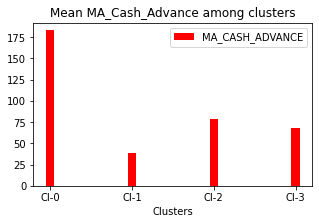

In [42]:
fig,ax=plt.subplots(figsize=(5,3))
index=np.arange(len(data_kpi_mean.columns))

MA_CASH_ADVANCE=(data_kpi_mean.loc['MA_CASH_ADVANCE',:].values)

bar_width=.10
b1=plt.bar(index,MA_CASH_ADVANCE,color='r',label='MA_CASH_ADVANCE',width=bar_width)

plt.xlabel("Clusters")
plt.title("Mean MA_Cash_Advance among clusters")
plt.xticks(index, ('Cl-0', 'Cl-1', 'Cl-2', 'Cl-3'))
plt.legend()
plt.savefig("Segmentation Analysis1.png")

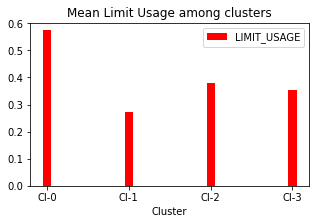

In [43]:
fig,ax=plt.subplots(figsize=(5,3))
index=np.arange(len(data_kpi_mean.columns))

LIMIT_USAGE=(data_kpi_mean.loc['LIMIT_USAGE',:].values)

bar_width=.10
b1=plt.bar(index,LIMIT_USAGE,color='r',label='LIMIT_USAGE',width=bar_width)

plt.xlabel("Cluster")
plt.title("Mean Limit Usage among clusters")
plt.xticks(index, ('Cl-0', 'Cl-1', 'Cl-2', 'Cl-3'))
plt.legend()
plt.savefig("Segmentation Analysis2.png")

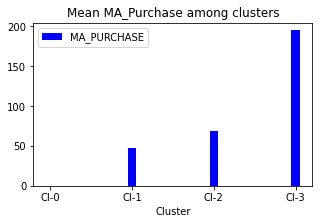

In [44]:
fig,ax=plt.subplots(figsize=(5,3))
index=np.arange(len(data_kpi_mean.columns))

MA_PURCHASE=(data_kpi_mean.loc['MA_PURCHASE',:].values)

bar_width=.10
b1=plt.bar(index,MA_PURCHASE,color='b',label='MA_PURCHASE',width=bar_width)

plt.xlabel("Cluster")
plt.title("Mean MA_Purchase among clusters")
plt.xticks(index, ('Cl-0', 'Cl-1', 'Cl-2', 'Cl-3'))
plt.legend()
plt.savefig("Segmentation Analysis3.png")

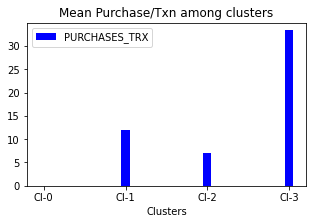

In [45]:
fig,ax=plt.subplots(figsize=(5,3))
index=np.arange(len(data_kpi_mean.columns))

PURCHASES_TRX=(data_kpi_mean.loc['PURCHASES_TRX',:].values)

bar_width=.10
b1=plt.bar(index,PURCHASES_TRX,color='b',label='PURCHASES_TRX',width=bar_width)

plt.xlabel("Clusters")
plt.title("Mean Purchase/Txn among clusters")
plt.xticks(index, ('Cl-0', 'Cl-1', 'Cl-2', 'Cl-3'))
plt.legend()
plt.savefig("Segmentation Analysis4.png")

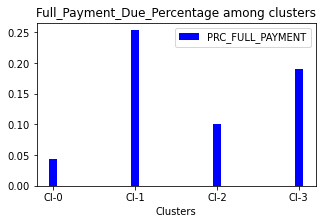

In [46]:
fig,ax=plt.subplots(figsize=(5,3))
index=np.arange(len(data_kpi_mean.columns))

PRC_FULL_PAYMENT=(data_kpi_mean.loc['PRC_FULL_PAYMENT',:].values)

bar_width=.10
b1=plt.bar(index,PRC_FULL_PAYMENT,color='b',label='PRC_FULL_PAYMENT',width=bar_width)

plt.xlabel("Clusters")
plt.title("Full_Payment_Due_Percentage among clusters")
plt.xticks(index, ('Cl-0', 'Cl-1', 'Cl-2', 'Cl-3'))
plt.legend()
plt.savefig("Segmentation Analysis5.png")

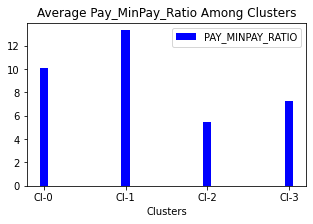

In [47]:
fig,ax=plt.subplots(figsize=(5,3))
index=np.arange(len(data_kpi_mean.columns))

PAY_MINPAY_RATIO=(data_kpi_mean.loc['PAY_MINPAY_RATIO',:].values)

bar_width=.10
b1=plt.bar(index,PAY_MINPAY_RATIO,color='b',label='PAY_MINPAY_RATIO',width=bar_width)

plt.xlabel("Clusters")
plt.title("Average Pay_MinPay_Ratio Among Clusters")
plt.xticks(index, ('Cl-0', 'Cl-1', 'Cl-2', 'Cl-3'))
plt.legend()
plt.savefig("Segmentation Analysis6.png")

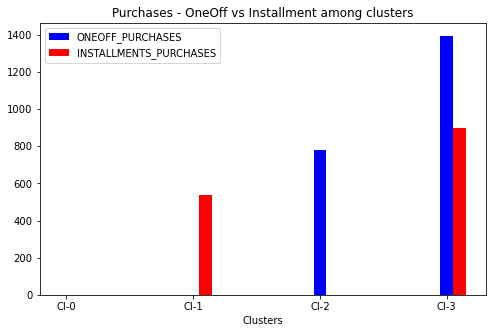

In [48]:
fig,ax=plt.subplots(figsize=(8,5))
index=np.arange(len(data_kpi_mean.columns))

ONEOFF_PURCHASES=(data_kpi_mean.loc['ONEOFF_PURCHASES',:].values)
INSTALLMENTS_PURCHASES=(data_kpi_mean.loc['INSTALLMENTS_PURCHASES',:].values)

bar_width=.10
b1=plt.bar(index,ONEOFF_PURCHASES,color='b',label='ONEOFF_PURCHASES',width=bar_width)
b2=plt.bar(index+bar_width,INSTALLMENTS_PURCHASES,color='r',label='INSTALLMENTS_PURCHASES',width=bar_width)

plt.xlabel("Clusters")
plt.title("Purchases - OneOff vs Installment among clusters")
plt.xticks(index, ('Cl-0', 'Cl-1', 'Cl-2', 'Cl-3'))
plt.legend()
plt.savefig("Segmentation Analysis7.png")

**Regular Withdrawers**(High Monthly Average Cash Advance)
**Low Credit Scores**(High Credit Utilization)

* C0 - Regular Withdrawers, Non-Purchaser, Non-Full_Due Payer, Low Credit Scorers
* C1 - Occasional Purchasers, Installment Purchasers, Prompt Full-Due Payers
* C2 - Occasional Purchasers, One-off Purchasers, Low Pay_MinPay Ratio
* C3 - Regular Purchasers, Both Purchasers, Mostly Full Due Payers

**Marketing Strategies:**

C0 - This group of customers seem to be utilizing the card mostly for taking cash advance and they are not doing purchases with the card. So providing cashback offers for first purchase could convert them gradually to purchasers. Since they seem to already have a high credit utilization, we should be cautious and refrain from offering any credit limit increase offers. Deals like providing low interest rate for installment purchases could also be benefitial.

C1 - This group consists of moderate spenders who purchase on installments and pay thier dues in full mostly. We should focus our marketing strategies on retaining these customers and maybe trying to increase their purchases by providing customized deals based on their spending pattern like movies, food deals etc.

C2 - This group also consists of moderate spenders but with one major difference from the previous cluster in the aspect of purchase type. This group mostly do one-off purchases. 

C3 - This group consists of the "Big Spenders" who purchase in both one-off and installments. They also mostly pay their dues as full. We must be fully concerned to have the lowest churn rate in this group. So, making these customers loyal by providing reward points will be highly beneficial. Also, we can off credit limit increase offers to this group.

In [49]:
data_label = pd.read_csv('credit_card_knn_imputed.csv')
data_raw = pd.read_csv('credit-card-data.csv')
# Conactenating labels found through Kmeans with data 
data_label=pd.concat([data_raw['CUST_ID'],data_label,
                        pd.Series(lut[kmeans_model.labels_],name='Group')],axis=1)

map_cluster = {0: "Withdrawers", 1: "Installment_Purchasers", 2: "One_Off_Purchasers", 3: "Big_Spenders"}
data_label = data_label.replace({"Group": map_cluster})

data_label.to_csv('Clustering_Output_Python.csv', index = False)